# Sales Data Analysis for 2019

## 1. Business Understanding

### 1.1. Introduction

In this project, we hope to create and implement a from start to finish business intelligence system that uses transactional data from 2019 to provide relevant insights to our client. The client has gathered data throughout the year but has not used it effectively to boost sales and enhance operational efficiency. Our goal is to thoroughly analyse the data and provide actionable insights that will help the customer identify chances for growth and optimisation.

## Project Description

This project involves the analysis of sales data collected by a client for the year 2019. The goal is to uncover insights that can help the client optimize their sales strategy, increase revenue, and identify operational inefficiencies. The analysis will follow the CRISP-DM framework, answering key business questions such as:

### Hypothesis

- Null Hypothesis (H0): There is a significant relationship between weekday and quantity ordered.

- Alternative Hypothesis (H1): There is no significant relationship between weekday and quantity ordered.

### Analytical Questions

1. How much money did we make this year? 

2. Can we identify any seasonality in the sales? 

3. What are our best and worst-selling products? 

4. How do sales compare to previous months or weeks? 

5. Which cities are our products delivered to most? 

6. How do product categories compare in revenue generated and quantities ordered? 

7. You are required to show additional details from your findings in your data. 


### Getting Started

### Importation of libraries

In [1]:
# Data Handling
import pyodbc
from dotenv import dotenv_values
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime  
from sqlalchemy import create_engine
import os
# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error


# Feature Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle
from scipy import stats



# Other Packages
import warnings

warnings.filterwarnings("ignore")

# Data Loading


In [2]:
# Directory path where CSV files for January to June are located
directory_path = r'C:\Users\HP\OneDrive\Desktop\capstone project\Sales-Data-Analysis-for-2019\notebook\data'


# List of file names for each month
file_names = [
    "Sales_January_2019.csv",
    "Sales_February_2019.csv",
    "Sales_March_2019.csv",
    "Sales_April_2019.csv",
    "Sales_May_2019.csv",
    "Sales_June_2019.csv"
]

# Generate file paths for each month
file_paths = [os.path.join(directory_path, file_name) for file_name in file_names]

# Load CSV files into separate DataFrames
data_frames = [pd.read_csv(file) for file in file_paths]

# Combine DataFrames into a single DataFrame
first_half_data = pd.concat(data_frames, ignore_index=True)

# View first half of the dataset
first_half_data.head()

Order ID                   Product Quantity Ordered Price Each  \
0   141234                    iPhone                1        700   
1   141235  Lightning Charging Cable                1      14.95   
2   141236          Wired Headphones                2      11.99   
3   141237          27in FHD Monitor                1     149.99   
4   141238          Wired Headphones                1      11.99   

       Order Date                       Purchase Address  
0  01/22/19 21:25        944 Walnut St, Boston, MA 02215  
1  01/28/19 14:15       185 Maple St, Portland, OR 97035  
2  01/17/19 13:33  538 Adams St, San Francisco, CA 94016  
3  01/05/19 20:33     738 10th St, Los Angeles, CA 90001  
4  01/25/19 11:59          387 10th St, Austin, TX 73301

#### Loading the second data from SQL database

In [3]:
# Loading environment variables from .env file
environment_variables = dotenv_values('.env')
 
# Getting the values for the credentials set in the .env file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")
 
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
# Connecting to the server
try:
    connection = pyodbc.connect(connection_string)
    print("Connection successful")
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful


In [4]:
# Define SQL queries
sql_queries = [
    'SELECT * FROM dbo.Sales_August_2019',
    'SELECT * FROM dbo.Sales_July_2019',
    'SELECT * FROM dbo.Sales_September_2019',
    'SELECT * FROM dbo.Sales_October_2019',
    'SELECT * FROM dbo.Sales_November_2019',
    'SELECT * FROM dbo.Sales_December_2019'
]

# Execute queries and fetch data into DataFrames
data_frames = []
for sql_query in sql_queries:
    df = pd.read_sql(sql_query, connection)
    data_frames.append(df)

# Combine DataFrames into a single DataFrame
second_half_data = pd.concat(data_frames, ignore_index=True)

# View second half of the dataset
second_half_data.head()

Order_ID                     Product  Quantity_Ordered  Price_Each  \
0  236670.0            Wired Headphones               2.0   11.990000   
1  236671.0  Bose SoundSport Headphones               1.0   99.989998   
2  236672.0                      iPhone               1.0  700.000000   
3  236673.0       AA Batteries (4-pack)               2.0    3.840000   
4  236674.0       AA Batteries (4-pack)               2.0    3.840000   

                    Order_Date                      Purchase_Address  
0  2031-08-19 22:21:00.0000000      359 Spruce St, Seattle, WA 98101  
1  2015-08-19 15:11:00.0000000        492 Ridge St, Dallas, TX 75001  
2  2006-08-19 14:40:00.0000000        149 7th St, Portland, OR 97035  
3  2029-08-19 20:59:00.0000000     631 2nd St, Los Angeles, CA 90001  
4  2015-08-19 19:53:00.0000000  736 14th St, New York City, NY 10001

### 3. Data Preparation
3.1. Data Cleaning

3.1.1. Standardize columns for both datasets.

In [5]:
# Display the columns for the first half of the dataframe
first_half_data.columns

Index(['Order ID', 'Product', 'Quantity Ordered', 'Price Each', 'Order Date',
       'Purchase Address'],
      dtype='object')

In [6]:
# Display the columns for the second half of the dataframe
second_half_data.columns

Index(['Order_ID', 'Product', 'Quantity_Ordered', 'Price_Each', 'Order_Date',
       'Purchase_Address'],
      dtype='object')

- Column names in the first half include 'Order ID', 'Product', 'Quantity Ordered', 'Price Each', 'Order Date', and 'Purchase Address', whereas the second half has 'Order_ID', 'Product', 'Quantity_Ordered', 'Price_Each', 'Order_Date', and 'Purchase_Address'. First, we need to standardise the column names.

In [7]:
# Rename columns of the first half of the dataset
first_half_data.columns = ['Order_ID', 'Product', 'Quantity_Ordered', 'Price_Each', 'Order_Date', 'Purchase_Address']
first_half_data.columns

Index(['Order_ID', 'Product', 'Quantity_Ordered', 'Price_Each', 'Order_Date',
       'Purchase_Address'],
      dtype='object')

### 3.1.2. Concatenate Dataset

In [8]:
# Concatenate the two halves along the rows axis
full_year_data = pd.concat([first_half_data, second_half_data], ignore_index=True)

# Display the combined dataset
full_year_data.head()

Order_ID                   Product Quantity_Ordered Price_Each  \
0   141234                    iPhone                1        700   
1   141235  Lightning Charging Cable                1      14.95   
2   141236          Wired Headphones                2      11.99   
3   141237          27in FHD Monitor                1     149.99   
4   141238          Wired Headphones                1      11.99   

       Order_Date                       Purchase_Address  
0  01/22/19 21:25        944 Walnut St, Boston, MA 02215  
1  01/28/19 14:15       185 Maple St, Portland, OR 97035  
2  01/17/19 13:33  538 Adams St, San Francisco, CA 94016  
3  01/05/19 20:33     738 10th St, Los Angeles, CA 90001  
4  01/25/19 11:59          387 10th St, Austin, TX 73301

### 3.1.3. Check data structure

In [9]:
full_year_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order_ID          186110 non-null  object
 1   Product           186305 non-null  object
 2   Quantity_Ordered  186110 non-null  object
 3   Price_Each        186110 non-null  object
 4   Order_Date        186110 non-null  object
 5   Purchase_Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


- The table above shows the amount of values in each column, as well as the data type.
- The datatypes for Order ID, Quantity Ordered, Price Each, and Order Date are incorrect and must be corrected.
- To establish an accurate dataset for this study, additional characteristics will be generated while others will be removed.

In [10]:
f'There are {full_year_data.shape[0]} rows and {full_year_data.shape[1]} columns in the dataset.'

'There are 186850 rows and 6 columns in the dataset.'

### 3.1.4. Handle missing values

In [11]:
# Check null values in the dataset
full_year_data.isnull().sum()

Order_ID            740
Product             545
Quantity_Ordered    740
Price_Each          740
Order_Date          740
Purchase_Address    545
dtype: int64

In [12]:
# Confirm rows with null values in the dataset
missing_values = first_half_data[full_year_data.columns].isnull().any(axis=1)
rows_with_missing_values = first_half_data[missing_values]
rows_with_missing_values.head(50)

Order_ID Product Quantity_Ordered Price_Each Order_Date Purchase_Address
664        NaN     NaN              NaN        NaN        NaN              NaN
678        NaN     NaN              NaN        NaN        NaN              NaN
797        NaN     NaN              NaN        NaN        NaN              NaN
876        NaN     NaN              NaN        NaN        NaN              NaN
1299       NaN     NaN              NaN        NaN        NaN              NaN
1491       NaN     NaN              NaN        NaN        NaN              NaN
1699       NaN     NaN              NaN        NaN        NaN              NaN
3047       NaN     NaN              NaN        NaN        NaN              NaN
3082       NaN     NaN              NaN        NaN        NaN              NaN
3584       NaN     NaN              NaN        NaN        NaN              NaN
3659       NaN     NaN              NaN        NaN        NaN              NaN
4689       NaN     NaN              NaN        NaN        NaN              NaN
5061       NaN     NaN              NaN        NaN        NaN              NaN
5570       NaN     NaN              NaN        NaN        NaN              NaN
5607       NaN     NaN              NaN        NaN        NaN              NaN
6056       NaN     NaN              NaN        NaN        NaN              NaN
6504       NaN     NaN              NaN        NaN        NaN              NaN
6517       NaN     NaN              NaN        NaN        NaN              NaN
7855       NaN     NaN              NaN        NaN        NaN              NaN
8255       NaN     NaN              NaN        NaN        NaN              NaN
8257       NaN     NaN              NaN        NaN        NaN              NaN
8596       NaN     NaN              NaN        NaN        NaN              NaN
8623       NaN     NaN              NaN        NaN        NaN              NaN
9144       NaN     NaN              NaN        NaN        NaN              NaN
9631       NaN     NaN              NaN        NaN        NaN              NaN
9664       NaN     NaN              NaN        NaN        NaN              NaN
9798       NaN     NaN              NaN        NaN        NaN              NaN
9892       NaN     NaN              NaN        NaN        NaN              NaN
9895       NaN     NaN              NaN        NaN        NaN              NaN
11211      NaN     NaN              NaN        NaN        NaN              NaN
11240      NaN     NaN              NaN        NaN        NaN              NaN
11497      NaN     NaN              NaN        NaN        NaN              NaN
11696      NaN     NaN              NaN        NaN        NaN              NaN
11750      NaN     NaN              NaN        NaN        NaN              NaN
12135      NaN     NaN              NaN        NaN        NaN              NaN
12255      NaN     NaN              NaN        NaN        NaN              NaN
12471      NaN     NaN              NaN        NaN        NaN              NaN
12841      NaN     NaN              NaN        NaN        NaN              NaN
13103      NaN     NaN              NaN        NaN        NaN              NaN
13426      NaN     NaN              NaN        NaN        NaN              NaN
13852      NaN     NaN              NaN        NaN        NaN              NaN
14126      NaN     NaN              NaN        NaN        NaN              NaN
14352      NaN     NaN              NaN        NaN        NaN              NaN
15447      NaN     NaN              NaN        NaN        NaN              NaN
15469      NaN     NaN              NaN        NaN        NaN              NaN
15759      NaN     NaN              NaN        NaN        NaN              NaN
16048      NaN     NaN              NaN        NaN        NaN              NaN
16565      NaN     NaN              NaN        NaN        NaN              NaN
16630      NaN     NaN              NaN        NaN        NaN              NaN
17057      NaN     NaN              NaN        NaN      

In [13]:
# View the last 20 rows for the missing values
rows_with_missing_values.tail(20)

Order_ID Product Quantity_Ordered Price_Each Order_Date Purchase_Address
78221      NaN     NaN              NaN        NaN        NaN              NaN
79484      NaN     NaN              NaN        NaN        NaN              NaN
80030      NaN     NaN              NaN        NaN        NaN              NaN
80054      NaN     NaN              NaN        NaN        NaN              NaN
80134      NaN     NaN              NaN        NaN        NaN              NaN
80373      NaN     NaN              NaN        NaN        NaN              NaN
80999      NaN     NaN              NaN        NaN        NaN              NaN
81356      NaN     NaN              NaN        NaN        NaN              NaN
82758      NaN     NaN              NaN        NaN        NaN              NaN
82979      NaN     NaN              NaN        NaN        NaN              NaN
83548      NaN     NaN              NaN        NaN        NaN              NaN
83774      NaN     NaN              NaN        NaN        NaN              NaN
83975      NaN     NaN              NaN        NaN        NaN              NaN
84276      NaN     NaN              NaN        NaN        NaN              NaN
84376      NaN     NaN              NaN        NaN        NaN              NaN
84570      NaN     NaN              NaN        NaN        NaN              NaN
84643      NaN     NaN              NaN        NaN        NaN              NaN
84662      NaN     NaN              NaN        NaN        NaN              NaN
84735      NaN     NaN              NaN        NaN        NaN              NaN
85355      NaN     NaN              NaN        NaN        NaN              NaN

- Because the rows with missing values in the dataset have all columns that are missing, we cannot impute the missing values, hence we remove the null values from the dataset.

In [14]:
# Drop null values
full_year_data.dropna(inplace=True)

# Check null values to confirm dropping of the null values
full_year_data.isnull().sum()

Order_ID            0
Product             0
Quantity_Ordered    0
Price_Each          0
Order_Date          0
Purchase_Address    0
dtype: int64

### 3.1.5 Remove duplicates

In [15]:
# Check duplicates in the dataset
f'There are {full_year_data.duplicated().sum()} duplicated rows in the dataset.'

'There are 423 duplicated rows in the dataset.'

In [16]:
# Confirm duplicated rows in the dataset
duplicates = full_year_data[full_year_data.duplicated()]
duplicates

Order_ID                 Product  Quantity_Ordered  Price_Each  \
875       142071   AA Batteries (4-pack)                 1        3.84   
1102    Order ID                 Product  Quantity Ordered  Price Each   
1194    Order ID                 Product  Quantity Ordered  Price Each   
1897    Order ID                 Product  Quantity Ordered  Price Each   
2463    Order ID                 Product  Quantity Ordered  Price Each   
...          ...                     ...               ...         ...   
181627  314675.0   AA Batteries (4-pack)               1.0        3.84   
182185  315204.0        Wired Headphones               1.0       11.99   
182973  315955.0         ThinkPad Laptop               1.0   999.98999   
183200  316173.0  AAA Batteries (4-pack)               1.0        2.99   
185085  317971.0   AA Batteries (4-pack)               1.0        3.84   

                         Order_Date                          Purchase_Address  
875                  01/17/19 23:02              131 2nd St, Boston, MA 02215  
1102                     Order Date                          Purchase Address  
1194                     Order Date                          Purchase Address  
1897                     Order Date                          Purchase Address  
2463                     Order Date                          Purchase Address  
...                             ...                                       ...  
181627  2026-12-19 09:01:00.0000000      927 13th St, San Francisco, CA 94016  
182185  2012-12-19 12:41:00.0000000       680 6th St, San Francisco, CA 94016  
182973  2026-12-19 17:28:00.0000000        588 Chestnut St, Seattle, WA 98101  
183200  2022-12-19 22:44:00.0000000         907 Sunset St, Portland, OR 97035  
185085  2017-12-19 18:39:00.0000000  250 Chestnut St, San Francisco, CA 94016  

[423 rows x 6 columns]

The duplicated rows in the dataset will be dealt with by keeping the first occurence and dropping every other instance.

In [17]:
# Drop duplicates
full_year_data.drop_duplicates(keep='first', inplace=True)

# Confirm drop
f'There are {full_year_data.duplicated().sum()} duplicated rows in the dataset now.'

'There are 0 duplicated rows in the dataset now.'

### 3.1.6. Check columns unique values

In [18]:
# Check unique values for product column
full_year_data['Product'].unique()

array(['iPhone', 'Lightning Charging Cable', 'Wired Headphones',
       '27in FHD Monitor', 'AAA Batteries (4-pack)',
       '27in 4K Gaming Monitor', 'USB-C Charging Cable',
       'Bose SoundSport Headphones', 'Apple Airpods Headphones',
       'Macbook Pro Laptop', 'Flatscreen TV', 'Vareebadd Phone',
       'AA Batteries (4-pack)', 'Google Phone', '20in Monitor',
       '34in Ultrawide Monitor', 'ThinkPad Laptop', 'LG Dryer',
       'LG Washing Machine', 'Product'], dtype=object)

- The Product value in the Product column must be inspected to validate the value

In [19]:
# Check rows with Product value as value
full_year_data[full_year_data['Product'] == 'Product']

Order_ID  Product  Quantity_Ordered  Price_Each  Order_Date  \
1073  Order ID  Product  Quantity Ordered  Price Each  Order Date   

      Purchase_Address  
1073  Purchase Address

This row in the dataset must be removed since it is invalid and contains incorrect values.

In [20]:
# Drop row with invalid column values
invalid_values = full_year_data[full_year_data['Product'] == 'Product'].index
full_year_data.drop(index=invalid_values, inplace=True)

In [21]:
# Confirm drop of row
full_year_data[full_year_data['Product'] == 'Product']

Empty DataFrame
Columns: [Order_ID, Product, Quantity_Ordered, Price_Each, Order_Date, Purchase_Address]
Index: []

In [22]:
# Inspect the Purchase Address column
full_year_data['Purchase_Address']

0                944 Walnut St, Boston, MA 02215
1               185 Maple St, Portland, OR 97035
2          538 Adams St, San Francisco, CA 94016
3             738 10th St, Los Angeles, CA 90001
4                  387 10th St, Austin, TX 73301
                           ...                  
186845    14 Madison St, San Francisco, CA 94016
186846      549 Willow St, Los Angeles, CA 90001
186847          273 Wilson St, Seattle, WA 98101
186848            778 River St, Dallas, TX 75001
186849    747 Chestnut St, Los Angeles, CA 90001
Name: Purchase_Address, Length: 185686, dtype: object

- The purchasing address column contains numerous pieces of information that will be splitted for easier dataset analysis.

- Columns such as Street Name, City, State, and ZIP Code will be taken from this column, which will then be removed.

In [23]:
# Check unique values in the Order Date column
full_year_data['Order_Date'].unique()

array(['01/22/19 21:25', '01/28/19 14:15', '01/17/19 13:33', ...,
       '2001-12-19 12:01:00.0000000', '2009-12-19 06:43:00.0000000',
       '2003-12-19 10:39:00.0000000'], dtype=object)

From the output for the unique values in the order date column, we can see that there are dates other than 2019 that we will need to remove in order to focus our study on the required date alone.

### 3.1.7. Convert data types

In [24]:
# Convert 'Order_Date' to datetime

full_year_data['Order_Date'] = pd.to_datetime(full_year_data['Order_Date'])

# Convert 'Quantity_Ordered' and 'Price_Each' to float


# Convert 'Price Each' column to numeric
full_year_data['Price_Each'] = pd.to_numeric(full_year_data['Price_Each'])

# Convert 'Quantity Ordered' column to numeric
full_year_data['Quantity_Ordered'] = pd.to_numeric(full_year_data['Quantity_Ordered'], downcast='integer')

# Convert 'Order_ID' column in the first dataset to float64
full_year_data['Order_ID'] = pd.to_numeric(full_year_data['Order_ID'], downcast='integer')

In [25]:
full_year_data['Order_Date'].unique()

<DatetimeArray>
['2019-01-22 21:25:00', '2019-01-28 14:15:00', '2019-01-17 13:33:00',
 '2019-01-05 20:33:00', '2019-01-25 11:59:00', '2019-01-29 20:22:00',
 '2019-01-26 12:16:00', '2019-01-05 12:04:00', '2019-01-01 10:30:00',
 '2019-01-22 21:20:00',
 ...
 '2003-12-19 05:50:00', '2023-12-19 14:08:00', '2013-12-19 07:25:00',
 '2011-12-19 21:24:00', '2007-12-19 08:25:00', '2030-12-19 01:06:00',
 '2011-12-19 20:58:00', '2001-12-19 12:01:00', '2009-12-19 06:43:00',
 '2003-12-19 10:39:00']
Length: 142395, dtype: datetime64[ns]

In [26]:
# Check data info to confirm changes
full_year_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185686 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order_ID          185686 non-null  int32         
 1   Product           185686 non-null  object        
 2   Quantity_Ordered  185686 non-null  int8          
 3   Price_Each        185686 non-null  float64       
 4   Order_Date        185686 non-null  datetime64[ns]
 5   Purchase_Address  185686 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int8(1), object(2)
memory usage: 8.0+ MB


### 3.2. Data Transformation
#### 3.2.1. Generate new features

In [27]:
# Filter out 2019 data from the entire dataset provided
data_2019 = full_year_data[full_year_data['Order_Date'].dt.year == 2019]
data_2019.head()

Order_ID                   Product  Quantity_Ordered  Price_Each  \
0    141234                    iPhone                 1      700.00   
1    141235  Lightning Charging Cable                 1       14.95   
2    141236          Wired Headphones                 2       11.99   
3    141237          27in FHD Monitor                 1      149.99   
4    141238          Wired Headphones                 1       11.99   

           Order_Date                       Purchase_Address  
0 2019-01-22 21:25:00        944 Walnut St, Boston, MA 02215  
1 2019-01-28 14:15:00       185 Maple St, Portland, OR 97035  
2 2019-01-17 13:33:00  538 Adams St, San Francisco, CA 94016  
3 2019-01-05 20:33:00     738 10th St, Los Angeles, CA 90001  
4 2019-01-25 11:59:00          387 10th St, Austin, TX 73301

In [28]:
# Generate column for sales
data_2019['Sales'] = data_2019['Quantity_Ordered'] * data_2019['Price_Each']

In [29]:
# Split the value in the Purchase Address into Street Address, City, and State/ZIP Code
data_2019[['Street_Address', 'City','State/ZIP_Code']] = data_2019['Purchase_Address'].astype('str').str.split(',', expand=True)
data_2019.head()

Order_ID                   Product  Quantity_Ordered  Price_Each  \
0    141234                    iPhone                 1      700.00   
1    141235  Lightning Charging Cable                 1       14.95   
2    141236          Wired Headphones                 2       11.99   
3    141237          27in FHD Monitor                 1      149.99   
4    141238          Wired Headphones                 1       11.99   

           Order_Date                       Purchase_Address   Sales  \
0 2019-01-22 21:25:00        944 Walnut St, Boston, MA 02215  700.00   
1 2019-01-28 14:15:00       185 Maple St, Portland, OR 97035   14.95   
2 2019-01-17 13:33:00  538 Adams St, San Francisco, CA 94016   23.98   
3 2019-01-05 20:33:00     738 10th St, Los Angeles, CA 90001  149.99   
4 2019-01-25 11:59:00          387 10th St, Austin, TX 73301   11.99   

  Street_Address            City State/ZIP_Code  
0  944 Walnut St          Boston       MA 02215  
1   185 Maple St        Portland       OR 97035  
2   538 Adams St   San Francisco       CA 94016  
3    738 10th St     Los Angeles       CA 90001  
4    387 10th St          Austin       TX 73301

In [30]:
# Split the State/ZIP_Code column into their respective individual columns
data_2019[['State', 'ZIP_Code']] = data_2019['State/ZIP_Code'].astype('str').str.split(expand=True)

In [31]:
# Drop Purchase Address and State/ZIP_Code columns
data_2019.drop(['Purchase_Address', 'State/ZIP_Code'],axis=1, inplace=True)

data_2019.head()

Order_ID                   Product  Quantity_Ordered  Price_Each  \
0    141234                    iPhone                 1      700.00   
1    141235  Lightning Charging Cable                 1       14.95   
2    141236          Wired Headphones                 2       11.99   
3    141237          27in FHD Monitor                 1      149.99   
4    141238          Wired Headphones                 1       11.99   

           Order_Date   Sales Street_Address            City State ZIP_Code  
0 2019-01-22 21:25:00  700.00  944 Walnut St          Boston    MA    02215  
1 2019-01-28 14:15:00   14.95   185 Maple St        Portland    OR    97035  
2 2019-01-17 13:33:00   23.98   538 Adams St   San Francisco    CA    94016  
3 2019-01-05 20:33:00  149.99    738 10th St     Los Angeles    CA    90001  
4 2019-01-25 11:59:00   11.99    387 10th St          Austin    TX    73301

In [32]:
data_2019['Day_of_Week']=data_2019['Order_Date'].dt.day_name()

In [33]:
# Group product into high-level and basic-level based on their prices

group_list = [] # Create an empty list

for value in data_2019['Price_Each'].values:   # Loop throught the values in the column
    if value > 99.99:
        group_list.append('High Level') # Assign High level if price is greater than 99.99
    else:
        group_list.append('Basic Level')    # Assign Basic level if price is less than 99.99

data_2019['Product_Group'] = group_list # Add the list to the dataframe

In [34]:
# Inspect dataframe
data_2019.head()

Order_ID                   Product  Quantity_Ordered  Price_Each  \
0    141234                    iPhone                 1      700.00   
1    141235  Lightning Charging Cable                 1       14.95   
2    141236          Wired Headphones                 2       11.99   
3    141237          27in FHD Monitor                 1      149.99   
4    141238          Wired Headphones                 1       11.99   

           Order_Date   Sales Street_Address            City State ZIP_Code  \
0 2019-01-22 21:25:00  700.00  944 Walnut St          Boston    MA    02215   
1 2019-01-28 14:15:00   14.95   185 Maple St        Portland    OR    97035   
2 2019-01-17 13:33:00   23.98   538 Adams St   San Francisco    CA    94016   
3 2019-01-05 20:33:00  149.99    738 10th St     Los Angeles    CA    90001   
4 2019-01-25 11:59:00   11.99    387 10th St          Austin    TX    73301   

  Day_of_Week Product_Group  
0     Tuesday    High Level  
1      Monday   Basic Level  
2    Thursday   Basic Level  
3    Saturday    High Level  
4      Friday   Basic Level

## 4. Exploratory Data Analysis (EDA)

#### 4.1. Summary statistics

#### 4.1.1. Analysis for numerical columns

In [35]:
# Select only numerical columns
numerical_columns = data_2019.select_dtypes(include=['number'])

# Generate summary statistics for numerical columns 
numerical_columns.describe().T

count           mean           std        min        25%  \
Order_ID          88478.0  185487.536540  29271.316178  141234.00  162462.25   
Quantity_Ordered  88478.0       1.125048      0.439837       1.00       1.00   
Price_Each        88478.0     185.523855    333.119010       2.99      11.95   
Sales             88478.0     186.644234    333.581138       2.99      11.95   

                        50%        75%       max  
Order_ID          183728.50  204923.75  319636.0  
Quantity_Ordered       1.00       1.00       9.0  
Price_Each            14.95     150.00    1700.0  
Sales                 14.95     150.00    3400.0

Iinsights from summary statistics
1. Order ID - The collection contains 185,686 order IDs, representing the total number of transactions.
- The order IDs range between 141,234 and 319,670, as indicated by the Min and Max figures.
- There are no missing values for order IDs because the count equals the total number of rows in the data set.

2. Ordered Quantity - The typical transaction includes 1.12 items.
- The standard deviation of approximately 0.44 suggests that the quantity ordered ranges somewhat around the mean.
- The least quantity ordered is one, and the greatest is nine, with the median and quartiles indicating that the majority of transactions are ordered in quantities of one.

3. Price Each
- The mean price of each item ordered is approximately 184.52, with a standard diviation of 332.84, indicating significant
variability in item prices.
- Item prices range from 2.99 to 1700.00.
- Most items have prices between 11.95 and 150.00, as indicated by the quartiles.

### 4.1.2. Analysis for categorical columns

In [36]:
# Check the descriptive statistics for the categorical columns
data_2019.describe(include='object').T

count unique                   top   freq
Product         88478     19  USB-C Charging Cable  10332
Street_Address  88478  39840            547 5th St      9
City            88478      9         San Francisco  21273
State           88478      8                    CA  35455
ZIP_Code        88478     10                 94016  21273
Day_of_Week     88478      7              Thursday  13433
Product_Group   88478      2           Basic Level  55532

- Using the descriptive statistics for the categorical columns provided above, we can calculate the number of values in the columns, the number of unique values, the most common values, and the frequency of the most common value.

## 4.2. Univariate Analysis

Text(0, 0.5, 'Total Daily Sales')

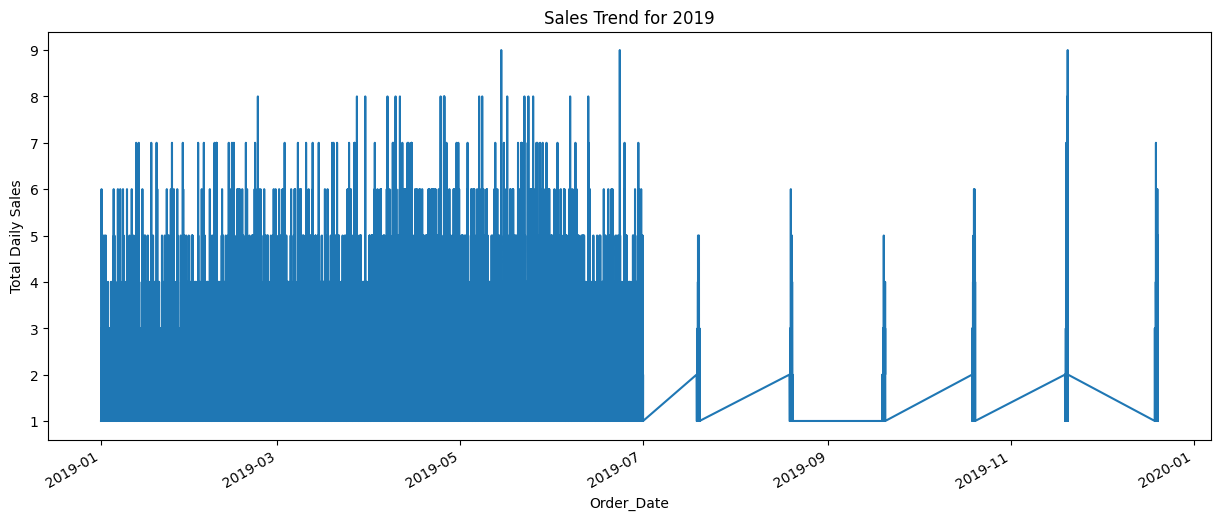

In [37]:
# Check trend of sales
daily_sales = data_2019.groupby('Order_Date')['Quantity_Ordered'].sum()
daily_sales.plot(kind='line',x='Order_Date', y='Quantity_Ordered', figsize=(15, 6), legend=False, title='Sales Trend for 2019')
plt.ylabel('Total Daily Sales')

A few insights from the graph are:

- Steady Sales (Early 2019 to Mid-2019): From January to around July 2019, there is a relatively consistent pattern of sales with most days showing sales between 4 and 7 units.
 
- Sudden Drops (After Mid-2019): There are noticeable drops in sales starting in July, with periods of very low or no sales, followed by spikes.

- Regular Spikes (Late 2019): From September onwards, the sales trend shows sharp spikes, likely indicating seasonal or periodic sales events (e.g., promotions, holidays). These spikes occur in September, November, and December.

- End-of-Year Surge: The highest sales spike occurs around November/December, which could indicate holiday or end-of-year sales boosts.

The sales trend suggests a relatively stable first half of the year, followed by more volatile sales in the second half, likely driven by special events or holidays.

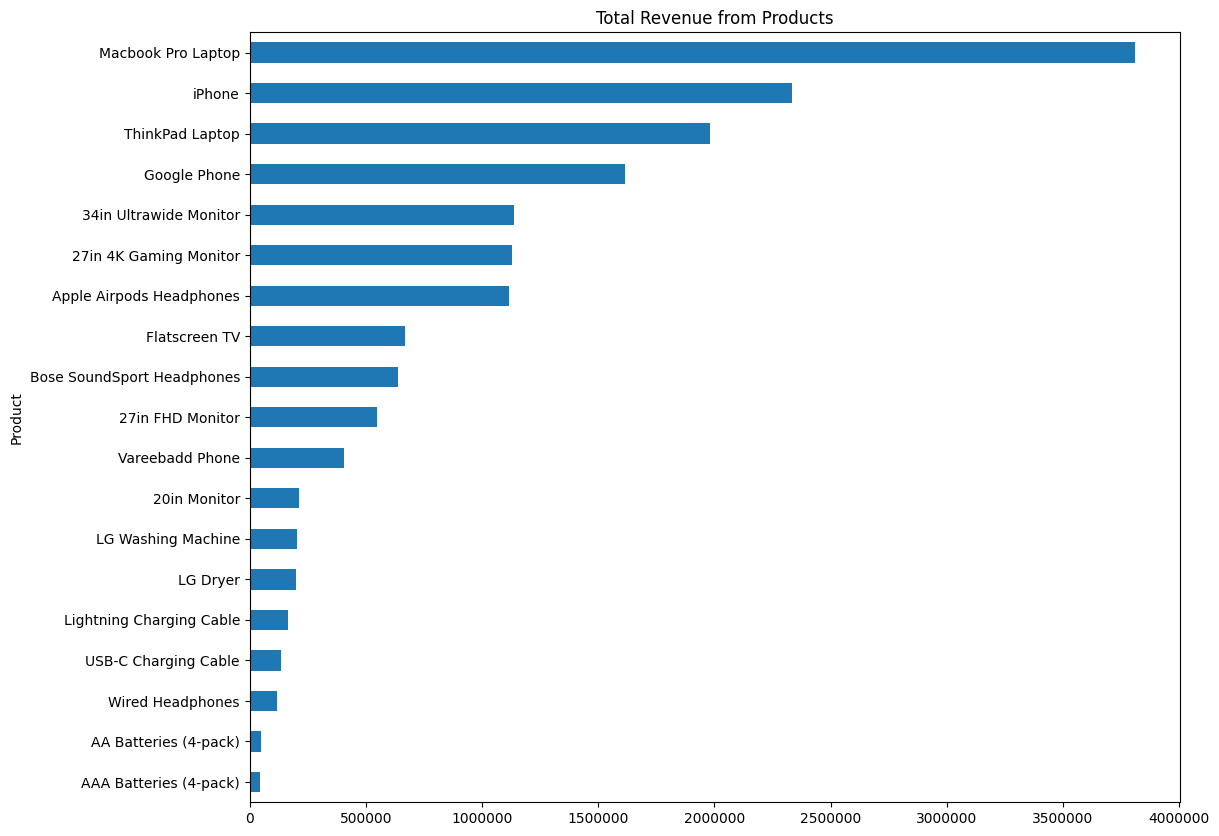

In [38]:
# Filter product sales for the days
product_sales = data_2019.groupby('Product')['Sales'].sum().sort_values(ascending=True).reset_index()

# Plot the total sales for the products
ax = product_sales.plot(kind='barh', x='Product', figsize=(12, 10), title='Total Revenue from Products', legend=False)
plt.ticklabel_format(axis='x', style='plain')

 Here are some key insights:

- Top Performers:
Macbook Pro Laptop generates the highest revenue, significantly outperforming other products.
iPhone and ThinkPad Laptop follow closely behind as other major revenue contributors.

- Mid-Range Performers:
Products like Google Phone, 34in Ultrawide Monitor, 27in 4K Gaming Monitor, and Apple Airpods Headphones are mid-tier in terms of revenue, contributing a decent share.

- Low Performers:
AA Batteries (4-pack), AAA Batteries (4-pack), and Wired Headphones contribute the least revenue, indicating these might be low-margin or low-sales items.

This chart suggests that high-end electronics (laptops, phones, monitors) drive most of the revenue, while accessories and smaller items bring in less revenue.

## 4.3. Bivariate Analysis

In [39]:
# Numeric-Numeric Relationship: Correlation Matrix
numeric_vars = ['Quantity_Ordered', 'Price_Each']
numeric_corr = full_year_data[numeric_vars].corr()

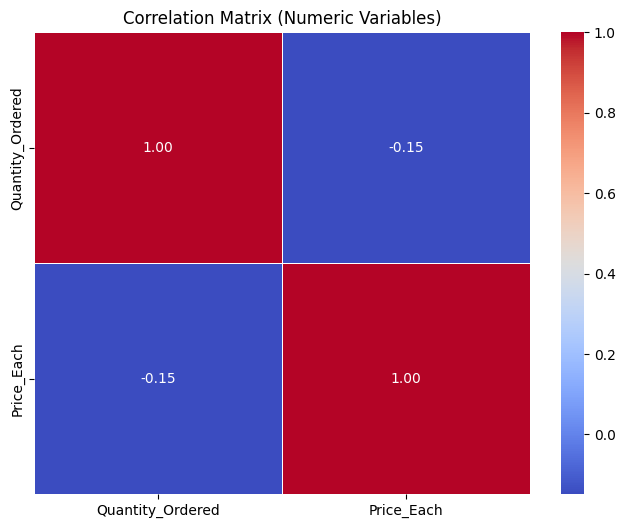

In [40]:
# Visualize correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix (Numeric Variables)')
plt.show()

The correlation matrix shows the relationship between two variables: Quantity Ordered and Price Each.

- Quantity Ordered and Price Each have a weak negative correlation of -0.15. This suggests that as the price of an item increases, the quantity ordered tends to decrease slightly, though the relationship is not strong.
- The diagonal elements (1.00) indicate that each variable is perfectly correlated with itself, which is expected.

Overall, there is a small inverse relationship between the price of a product and the quantity ordered.

## 4.3. Multivariate Analysis

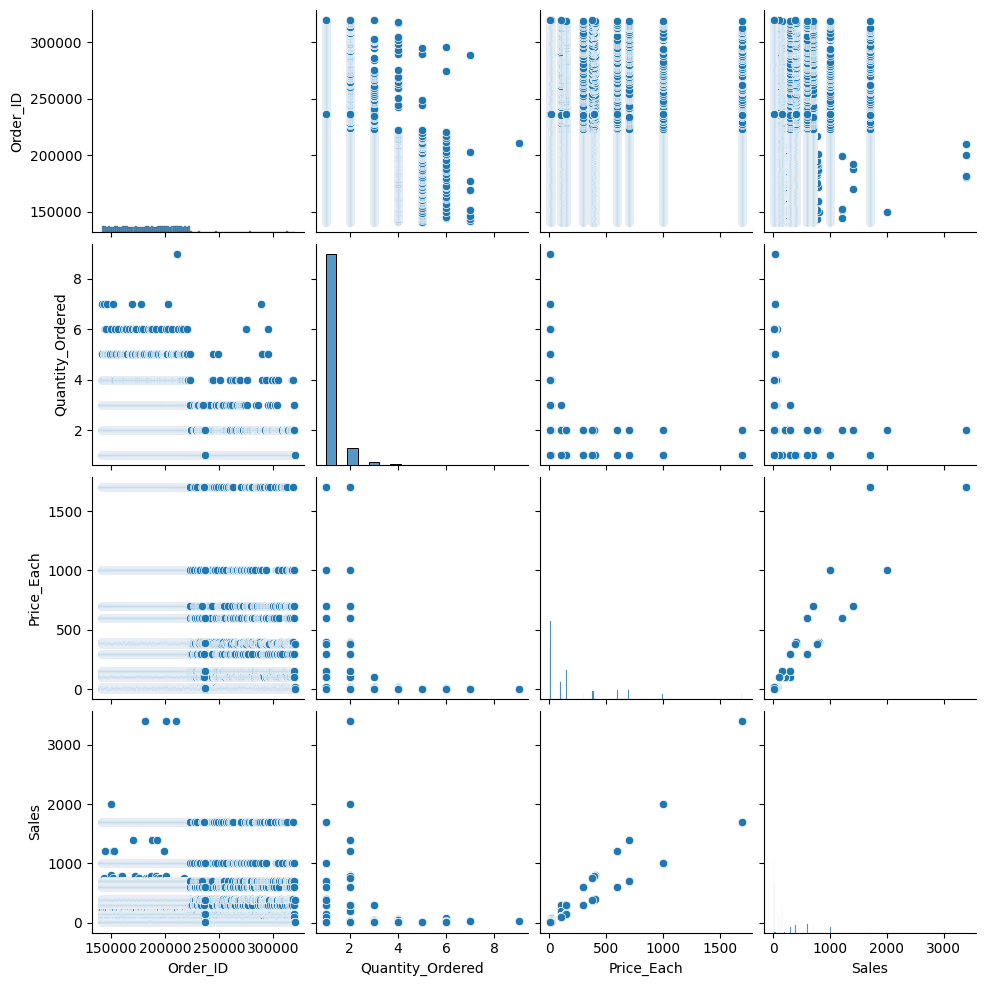

In [41]:
sns.pairplot(data_2019)
plt.show()

Here's a quick breakdown of insights:

- Quantity_Ordered vs. Sales: There is a strong positive correlation, meaning that as more products are ordered, sales increase.
- Price_Each vs. Sales: Another strong positive correlation, indicating that higher-priced products result in higher sales.
- Quantity_Ordered: Most orders are for smaller quantities (1-2 items), with fewer orders for larger quantities.
= Order_ID doesn't seem to show any meaningful relationship with other variables, as it's just a unique identifier.

These plots help identify trends and relationships in the data, such as how quantity and price affect total sales.

## 5. Answering Analytical Questions

#### 5.1. How much money did we make in 2019?

In [42]:
f"The total amount of money made in 2019 was ${format(data_2019['Sales'].sum(), ',.2f')}"

'The total amount of money made in 2019 was $16,513,908.56'

####  5.2. Can we identify any seasonality in the sales?

To identify seasonality in sales, we'll analyze the sales data over time, specifically by month. We'll plot the total sales for each month over the entire duration of the dataset and look for recurring patterns or trends.

1. Group the sales data by month.
2. Calculate the total sales for each month.
3. Plot the total sales for each month.

In [43]:
# Extract month from 'Order_Date'
data_2019['Order_Month'] = data_2019['Order_Date'].dt.month

# Calculate total sales for each month
monthly_sales = data_2019.groupby('Order_Month')['Sales'].sum()

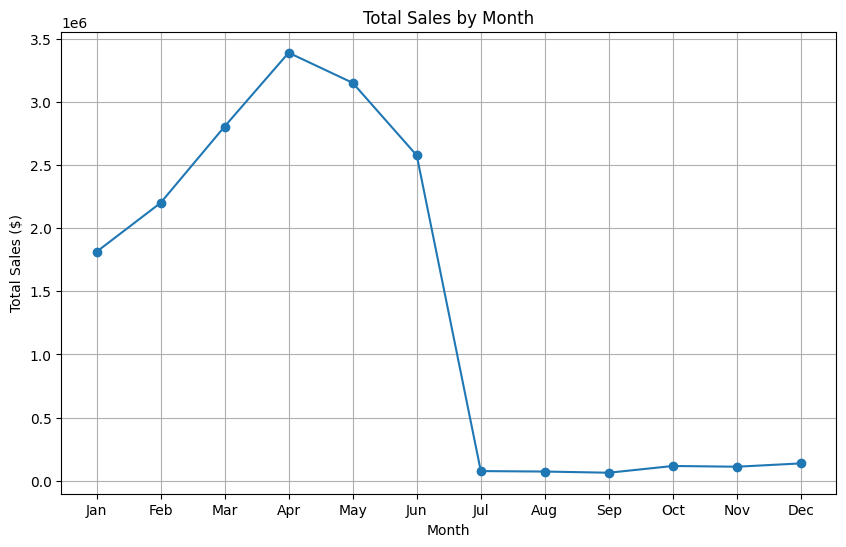

In [44]:
# Plot the data
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)

- Peak months: We see sales peaks in April and May.
- Opportunities for Improvement: By analysing revenue seasonality, the company can identify ways to capitalise on high months while mitigating obstacles during sluggish periods. This could include changing marketing methods, providing targeted promotions, or improving inventory management.

#### 5.3 What are our best and worst-selling products?

To determine the best and worst-selling products, we will tally the number of units sold and the total money earned for each product. Then we will identify the goods with the highest and lowest overall quantity and income.

In [45]:
# Calculate total quantity sold for each product
total_quantity_sold = data_2019.groupby('Product')['Quantity_Ordered'].sum().sort_values(ascending=False)

# Calculate total revenue generated for each product
total_revenue = data_2019.groupby('Product')['Sales'].sum().sort_values(ascending=False)

# Identify best-selling products (by quantity and revenue)
best_selling_by_quantity = total_quantity_sold.head(5)
best_selling_by_revenue = total_revenue.head(5)

# Identify worst-selling products (by quantity and revenue)
worst_selling_by_quantity = total_quantity_sold.tail(5)
worst_selling_by_revenue = total_revenue.tail(5)

In [46]:
# Display the results
print("Best-selling products by quantity:")
print(best_selling_by_quantity)
print("\nBest-selling products by revenue:")
print(best_selling_by_revenue)
print('='*50)
print("\nWorst-selling products by quantity:")
print(worst_selling_by_quantity)
print("\nWorst-selling products by revenue:")
print(worst_selling_by_revenue)

Best-selling products by quantity:
Product
AAA Batteries (4-pack)      14698
AA Batteries (4-pack)       13210
USB-C Charging Cable        11313
Lightning Charging Cable    11060
Wired Headphones             9817
Name: Quantity_Ordered, dtype: int64

Best-selling products by revenue:
Product
Macbook Pro Laptop        3.811400e+06
iPhone                    2.331700e+06
ThinkPad Laptop           1.982980e+06
Google Phone              1.617000e+06
34in Ultrawide Monitor    1.139210e+06
Name: Sales, dtype: float64

Worst-selling products by quantity:
Product
ThinkPad Laptop       1983
20in Monitor          1915
Vareebadd Phone       1020
LG Washing Machine     339
LG Dryer               331
Name: Quantity_Ordered, dtype: int64

Worst-selling products by revenue:
Product
Lightning Charging Cable    165346.999920
USB-C Charging Cable        135190.349917
Wired Headphones            117705.829912
AA Batteries (4-pack)        50726.399953
AAA Batteries (4-pack)       43947.020006
Name: Sales, 

#### 5.4 How do sales compare to previous months or weeks

In [47]:
# Extract month from 'Order_Date'
data_2019['Order_Month'] = data_2019['Order_Date'].dt.month

# Calculate total sales for each month
monthly_sales = data_2019.groupby('Order_Month')['Sales'].sum()

# Calculate month-over-month growth rate
monthly_sales_growth = monthly_sales.pct_change()
monthly_sales_growth 

Order_Month
1          NaN
2     0.213674
3     0.274943
4     0.208289
5    -0.070400
6    -0.182293
7    -0.970203
8    -0.047462
9    -0.127168
10    0.836886
11   -0.050412
12    0.237218
Name: Sales, dtype: float64

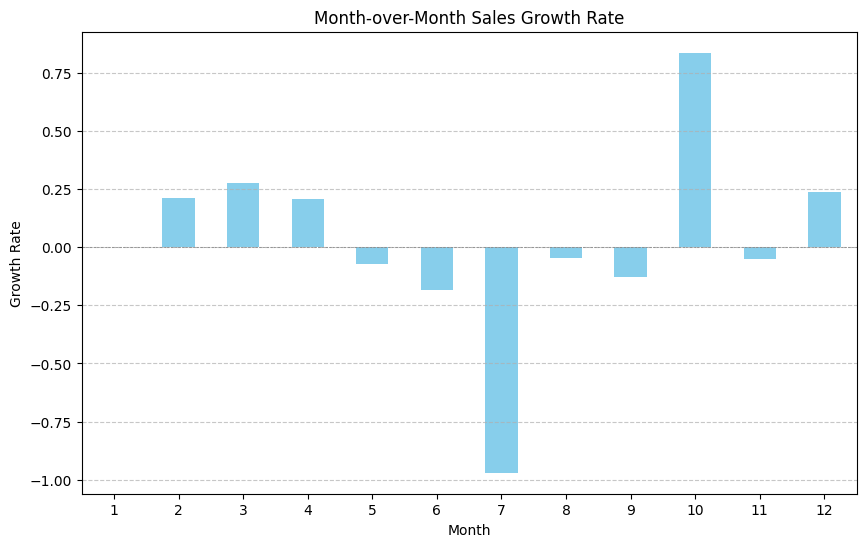

In [48]:
# Plot the month-over-month growth rate
plt.figure(figsize=(10, 6))
monthly_sales_growth.plot(kind='bar', color='skyblue')
plt.title('Month-over-Month Sales Growth Rate')
plt.xlabel('Month')
plt.ylabel('Growth Rate')
plt.xticks(rotation=0)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

- January to February: There is a positive growth rate of approximately 21.3%, indicating an increase in sales from January to February.

- February to March: Another positive growth rate of about 27.5%, indicating further growth in sales from February to March.

- March to April: Sales continue to grow with a positive growth rate of around 20.8% from March to April.

- April to May: However, there is a slight decrease in sales from April to May, indicated by a negative growth rate of approximately -7%.

- May to June: Sales decline further with a negative growth rate of about -18.2% from May to June.

- June to July: Sales decline further with a negative growth rate of about -97% from June to July.

- July to August: Sales decrease again, indicated by a negative growth rate of approximately -4.8% from July to August.

- August to September: The decline lessens slightly with a negative growth rate of about -12.7% from August to September.

- September to October: There is a significant increase in sales with a positive growth rate of approximately 83.7% from September to October.

- October to November: However, sales decline again with a negative growth rate of around -5% from October to November.

- November to December: Sales experience a substantial increase with a positive growth rate of about 23.7% from November to December.

- Overall, the month-over-month growth rates suggest that sales are increasing at a steady pace over the course of the year.

#### 5.5 Which cities are our products delivered to most?


- We will analyse the dataset's delivery addresses and count their frequency in each city.

- This can be accomplished by extracting the city names from the 'Purchase_Address' column and counting the number of times each city appears.

In [49]:
# Count the frequency of each city
city_frequency = data_2019['City'].value_counts()

# Display the top 5 cities with the most product deliveries
top_cities = city_frequency.head(5)
top_cities

City
San Francisco    21273
Los Angeles      14182
New York City    11805
Boston            9389
Atlanta           7167
Name: count, dtype: int64

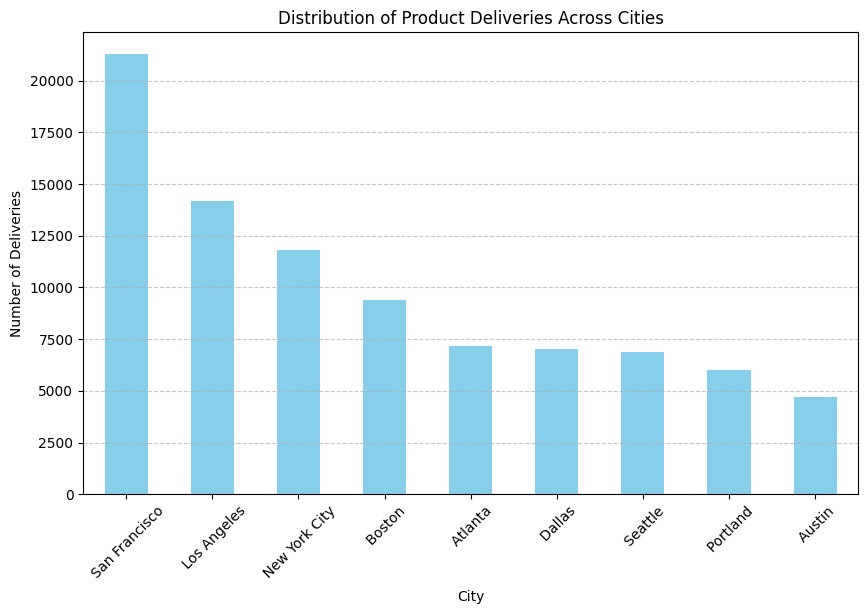

In [50]:
# Plot the distribution of product deliveries across cities
plt.figure(figsize=(10, 6))
city_frequency.plot(kind='bar', color='skyblue')
plt.title('Distribution of Product Deliveries Across Cities')
plt.xlabel('City')
plt.ylabel('Number of Deliveries')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

This bar chart shows the distribution of product deliveries across cities. Here's a quick insight:

- San Francisco has the highest number of product deliveries, significantly more than other cities.
- Los Angeles and New York City also have a high number of deliveries, but less than San Francisco.
- Cities like Boston, Atlanta, and Dallas are in the mid-range.
- Austin has the fewest product deliveries among the cities listed.

This suggests that San Francisco is the leading market for deliveries, while Austin has the lowest demand.

#### 5.6 How do product categories compare in revenue generated and quantities ordered?

In [51]:
# Define product categories based on product names
def categorize_product(product_name):
    if 'iPhone' in product_name:
        return 'Electronics'
    elif 'Charging Cable' in product_name:
        return 'Electronics'
    elif 'Headphones' in product_name:
        return 'Electronics'
    elif 'Monitor' in product_name:
        return 'Electronics'
    elif 'Batteries' in product_name:
        return 'Electronics'
    elif 'Phone' in product_name:
        return 'Electronics'
    else:
        return 'Other'

# Apply categorization to create a new 'Product_Category' column
data_2019['Product_Category'] = data_2019['Product'].apply(categorize_product)

# Calculate total revenue and total quantity ordered for each category
category_revenue = data_2019.groupby('Product_Category')['Sales'].sum()
category_quantity = data_2019.groupby('Product_Category')['Quantity_Ordered'].sum()

# Compare categories based on revenue
print("Total Revenue by Product Category:")
print(category_revenue.sort_values(ascending=False))

# Compare categories based on quantity ordered
print("\nTotal Quantity Ordered by Product Category:")
print(category_quantity.sort_values(ascending=False))

Total Revenue by Product Category:
Product_Category
Electronics    9.647628e+06
Other          6.866280e+06
Name: Sales, dtype: float64

Total Quantity Ordered by Product Category:
Product_Category
Electronics    92414
Other           7128
Name: Quantity_Ordered, dtype: int64


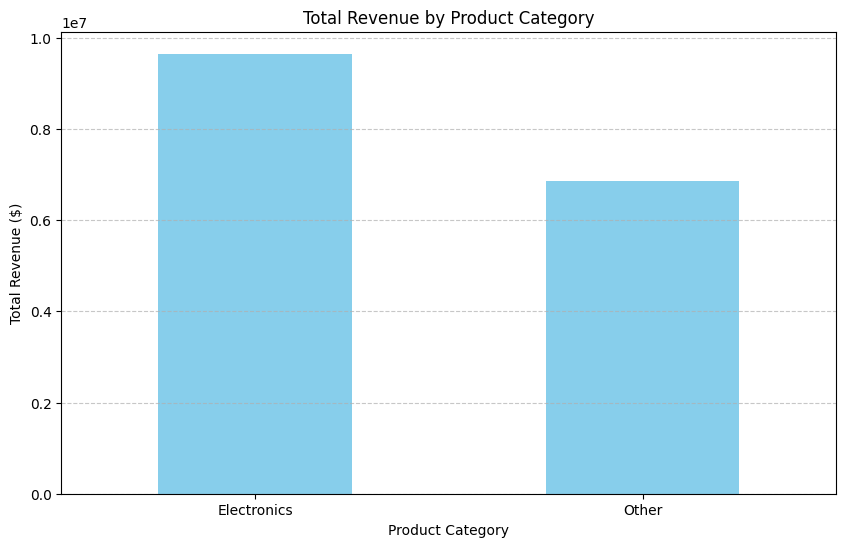

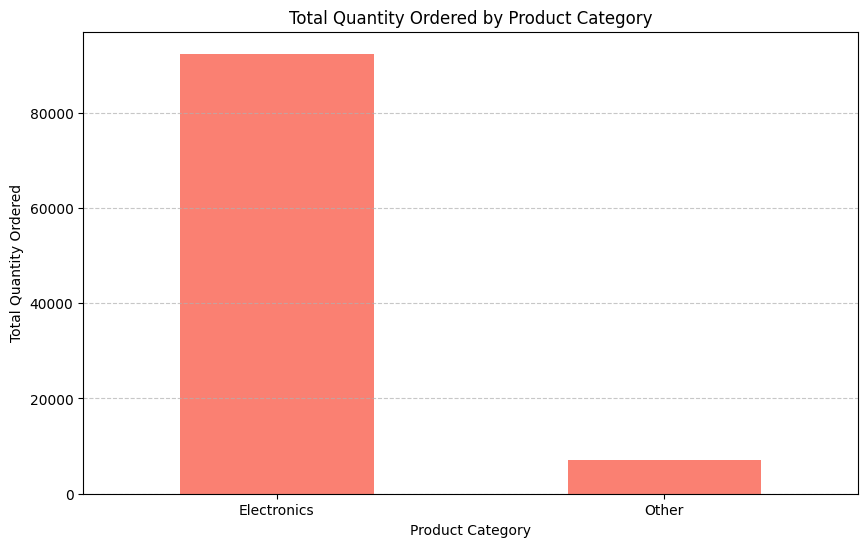

In [52]:
# Plotting total revenue by product category
plt.figure(figsize=(10, 6))
category_revenue.plot(kind='bar', color='skyblue')
plt.title('Total Revenue by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plotting total quantity ordered by product category
plt.figure(figsize=(10, 6))
category_quantity.plot(kind='bar', color='salmon')
plt.title('Total Quantity Ordered by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Quantity Ordered')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- These findings indicate that the "Electronics" category generates higher revenue and has a significantly higher quantity ordered compared to the "Other" category.

- This suggests that electronics products are the main drivers of sales revenue and volume in the dataset.

#### 5.7 You are required to show additional details from your findings in your data.

1. Revenue breakdown by category.

- The bar plot of total income by product category shows that the "Electronics" category earns much more money than the "Other" category. This indicates that electronics products are the key revenue drivers for the company.

2. Quantity-Ordered Comparison

- The bar plot depicting total quantity ordered by product category shows a similar tendency, with the "Electronics" category having a significantly higher quantity ordered than the "Other". This means that, while the "Other" category includes a wide range of products, electronics account for the majority of sales volume.

3. Diversification considerations

- While electronics items now account for the majority of income and sales volume, expanding product offerings in the "Other" category may reduce the risks associated with over-reliance on a single product category. Exploring new product lines or expanding existing ones may broaden the client base and improve overall market resilience.

### 5.8 Hypothesis
- Null Hypothesis (H0): There is a significant relationship between weekday and quantity ordered.

- Alternative Hypothesis (H1): There is no significant relationship between weekday and quantity ordered.

In [53]:
# Perform Spearman Rank correlation test
rho, p_value = stats.spearmanr(data_2019['Day_of_Week'], data_2019['Quantity_Ordered'])

# Define the significance level (alpha)
alpha = 0.05


# Print the results of the hypothesis test
print("\nResults of the hypothesis test:")
print("Spearman Correlation Coefficient (rho):", rho)
print("P-value:", p_value)

# Check if the p-value is less than alpha indicating statistical significance
if p_value < alpha:
    print("\nReject the null hypothesis")
    print("We conclude that there is not enough evidence to support the claim that there is a significant relationship between weekday and quantity ordered.")
else:
    print("\nFail to reject the null hypothesis")
    print("We conclude that there is enough evidence to support the claim that there is a significant relationship between weekday and quantity ordered.")


Results of the hypothesis test:
Spearman Correlation Coefficient (rho): 0.003381084626193035
P-value: 0.3145595189016607

Fail to reject the null hypothesis
We conclude that there is enough evidence to support the claim that there is a significant relationship between weekday and quantity ordered.


### Insights for the Hypothesis
- The lack of significant correlation between weekday and quantity ordered indicates that clients may not have regular purchase patterns dependent on the day of the week.

- Because the null hypothesis is not rejected, it follows that buyers will purchase identical quantities of products regardless of the day of the week. This shows that the day of the week may not play a significant role in influencing the quantity requested by clients.

- While weekday might not have a significant impact on quantity ordered, other factors such as product type, pricing strategies, marketing efforts, and customer demographics could play more influential roles in driving sales. Businesses can shift their focus to optimizing these aspects to maximize revenue and profitability.

## 6. Deployment

In [54]:
# Define the directory path
directory = '../data'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the CSV file
data_2019.to_csv(f'{directory}/cleaned_dataset.csv', index=False)